In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy.random as rnd
import os
import sys
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, ConvLSTM2D
from keras.callbacks import EarlyStopping
from keras import backend as K
import time

from functools import partial
from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Wavelet functions
# Definining variables for WT
# this is the wavelet creation call part...
current_level = 2
current_mode = 'constant'
current_wavelet = pywt.Wavelet('haar')

def save_as_csv(data_array, file_name="data"):
    output_name = file_name + ".csv"
    np.savetxt(output_name, data_array, delimiter=",", fmt='%-7.4f', 
               header=str(data_array.dtype.names).replace('(',"").replace(')',"").replace("#", "") + " ",
              comments='')
    
def apply_wt_once(data, wavelet='haar', level=2, mode='constant'):
    haar_dwt = pywt.wavedec(data, wavelet=wavelet, level=level, mode=mode)
    
    # delete the high frequencies from the decomposition
    #haar_dwt[1] = np.zeros_like(haar_dwt[1])
    haar_dwt[2] = np.zeros_like(haar_dwt[2])
  
    return pywt.waverec(haar_dwt, mode=mode, wavelet=wavelet)

def apply_wt_twice(data, wavelet='haar', level=2, mode='constant'):
    wt_results = apply_wt_once(data=data,
                        wavelet=current_wavelet,
                        level=current_level,
                        mode=current_mode)
    
    return apply_wt_once(data=wt_results,
                        wavelet=current_wavelet,
                        level=current_level,
                        mode=current_mode)

def get_accuracy(data1, data2):
    return np.std(data1-data2)

def apply_wt_twice_on_dataset(dataset, wavelet='haar', level=2, mode='constant'):
    #ignored_col_names = ('Ntime', 'time', 'Time') # from the SP500 dataset, might need some tweaking
    col_names = dataset.dtype.names
    results = np.zeros_like(dataset)

    #results[ignored_col_names[0]] = dataset[ignored_col_names[0]]
    #if ignored_col_names[1] in dataset.dtype.names:
    #    results[ignored_col_names[1]] = dataset[ignored_col_names[1]]
    #else:
    #    results[ignored_col_names[2]] = dataset[col_names[1]]
    
    for name in col_names:
        #if name not in ignored_col_names:
        temp = apply_wt_twice(
                            dataset[name],
                            wavelet=wavelet,
                            level=level,
                            mode=mode
                             )
        results[name] = temp[:len(dataset[name])]
    return results
 
def end_to_end_twice_wt_with_csv(input_file_name, output_file_name, wavelet='haar', level=2, mode='constant'):
    data_array = np.genfromtxt('data/' + input_file_name, delimiter=',', dtype=float, names=True)
    res = apply_wt_twice_on_dataset(data_array,
                                wavelet=wavelet,
                                level=level,
                                mode=mode)
    save_as_csv(res, file_name="data/data_wt/" + output_file_name)
    res = [list(x) for x in res]
    return np.array(res)

In [3]:
#Autoencoder functions

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                       activation, learning_rate = 0.005, l2_reg = 0.0005,
                      seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            if epoch % 500 == 0:
                print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]


In [4]:
#normalise dataset pre and post autoencoder input
def normalise_dataset(dataset):
    n_cols = dataset.shape[1]
    norm_dataset = np.zeros_like(dataset)
    for i in range(n_cols): 
        mean = np.sum(dataset[:,i])/len(dataset[:,i])
        std_dev = np.dot(dataset[:,i]-mean, dataset[:,i]-mean)/(len(dataset[:,i]) - 1)
        std_dev = np.sqrt(std_dev)
        norm_dataset[:,i] = (dataset[:,i] - mean) / std_dev

    return norm_dataset

In [5]:
# conversion code to create lookbacks for lstms
# convert an array of values into a dataset matrix
def create_dataset(trainX, trainY, look_back=1):
    dataX, dataY = [], []
    for i in range(len(trainX)-look_back-1):
        a = trainX[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(trainY[i + look_back-1])
    return np.array(dataX), np.array(dataY)

In [6]:
#Train the stacked autoencoder
#then take the latent layer

def sae(x_train, N_EPOCHS, BATCH_SIZE,LEARNING_RATE, neurons):
    reset_graph()
    ACTIVATION = tf.nn.tanh

    hidden_output1, W1, b1, W8, b8 = train_autoencoder(x_train, n_neurons=neurons[0], 
                                                       n_epochs=N_EPOCHS, 
                                                       batch_size=BATCH_SIZE, 
                                                       learning_rate=LEARNING_RATE,
                                                       activation=ACTIVATION)
    hidden_output2, W2, b2, W7, b7 = train_autoencoder(hidden_output1, n_neurons=neurons[1], 
                                                       n_epochs=N_EPOCHS, 
                                                       batch_size=BATCH_SIZE, 
                                                       learning_rate=LEARNING_RATE,
                                                       activation=ACTIVATION)
    hidden_output3, W3, b3, W6, b6 = train_autoencoder(hidden_output2, n_neurons=neurons[2], 
                                                       n_epochs=N_EPOCHS, 
                                                       batch_size=BATCH_SIZE, 
                                                       learning_rate=LEARNING_RATE,
                                                       activation=ACTIVATION)
    o4, W4, b4, W5, b5 = train_autoencoder(hidden_output3,n_neurons=neurons[3], 
                                                       n_epochs=N_EPOCHS, 
                                                       batch_size=BATCH_SIZE, 
                                                       learning_rate=LEARNING_RATE,
                                                       activation=ACTIVATION)


    #Extract the latent outputs from the stacked ae
    reset_graph()
    activation = ACTIVATION

    n_inputs = 1*(x_train.shape[1])

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    hidden1 = activation(tf.matmul(X, W1) + b1)
    hidden2 = activation(tf.matmul(hidden1, W2) + b2)
    hidden3 = activation(tf.matmul(hidden2, W3) + b3)
    hidden4 = activation(tf.matmul(hidden3, W4) + b4)
    hidden5 = activation(tf.matmul(hidden4, W5) + b5)
    hidden6 = activation(tf.matmul(hidden5, W6) + b6)
    hidden7 = activation(tf.matmul(hidden6, W7) + b7)
    
    
    #hidden1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    #hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2)
    #hidden3 = tf.nn.relu(tf.matmul(hidden2, W3) + b3)
    #hidden4 = tf.nn.relu(tf.matmul(hidden3, W4) + b4)
    #hidden5 = tf.nn.relu(tf.matmul(hidden4, W5) + b5)
    #hidden6 = tf.nn.relu(tf.matmul(hidden5, W6) + b6)
    #hidden7 = tf.nn.relu(tf.matmul(hidden6, W7) + b7)
    outputs = tf.matmul(hidden7, W8) + b8

    #unnecessary - should be the same as o4 but just to check
    with tf.Session() as sess:
            latent_val = hidden4.eval(feed_dict={X: x_train})

    # Normalise output of SAEs
    latent_val = normalise_dataset(latent_val)

    # Save output in .csv file
    latent_out = pd.DataFrame(latent_val) #latent_val
    latent_out.to_csv('data/auto_out.csv', index=False)
    
    reset_graph()
    
    return latent_val  

In [7]:
#for the moment just a holder function for running the lstm or mlp
#can tweak parameters depending on tests

def run_regression(trainX, trainY, testX, testY, look_back, LEARNING_RATE, BATCH_SIZE, EPOCHS, neurons, dropout, decay=0.0):
    #reset_graph()
    K.clear_session()
    # create and fit the LSTM network
    
    opti_adam = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    features = trainX.shape[1]
    lstm_features = trainX.shape[-1]

    model = Sequential()

    #lstm test
    if look_back != 0:
        for i in enumerate(neurons):
            if i[0] != len(neurons)-1:
                model.add(LSTM(i[1], input_shape=(look_back, lstm_features),  return_sequences=True, unroll=True))
                model.add((Dropout(dropout)))
                model.add(BatchNormalization())
            else:
                model.add(LSTM(i[1]))
                model.add((Dropout(dropout)))
                model.add(BatchNormalization())
    #MLP Test
    else:
        for i in enumerate(neurons): 
            model.add(Dense(i[1], input_dim=features, activation= 'relu'))
            model.add((Dropout(dropout)))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=opti_adam)
    history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        verbose=1, callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=5)], 
                        validation_data=(testX, testY)) #validation_split = 0.1)
    

    return model, history

In [8]:
#this is to create data set inputs to the mlp or lstm
def make_reg_data(latent_val, y_train, look_back):

    features = latent_val.shape[1]
    all_trainX = latent_val 

    trainX = all_trainX[:round(0.9*len(all_trainX))]
    testX = all_trainX[round(0.9*len(all_trainX)):]

    all_trainY = np.array(y_train[:-1])
    trainY = all_trainY[:round(0.9*len(all_trainY))]
    testY = all_trainY[round(0.9*len(all_trainY)):]
    
    if look_back != 0:
        ##### for an mlp dont do the lookback stuff ######
        trainX, trainY = create_dataset(trainX, trainY, look_back)
        testX, testY = create_dataset(testX, testY, look_back) 
    return trainX, trainY, testX, testY

In [9]:
#Function to enable live graph of losses as training progresses 
#note it is called in this cell also and used later
from IPython.display import clear_output

# Live plot for loss during training
# Taken from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        # Reset the plot to only have the last 100 epochs
        if len(self.x) % 100 == 0:
            self.on_train_begin()
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [10]:
#examine initial features
def make_raw_data(input_file, features, wavelet, normalise, cheat, cheat_fac):
    #including the creation of the wavelet stuff
    #returns normalised X, and target y, currently hard coded files
    #for targets it assumes a close price for the input file
    #also for now hard coded to data/data_wt
    
    raw_data = pd.read_csv("data/" + input_file)

    #set up with complete cheat features to check it can learn - an MLP does what about lSTM
    cheat_data = raw_data[features].copy() # raw_data[['Ntime', 'time', 'Close Price','Open Price']].copy()
    if cheat:
        cheat_data["Cheat"] = raw_data['Close Price'].shift(-1)
    cheat_data = cheat_data[:-1] #to keep it clean will take the last off whether cheat or not - because of y's
    #print(cheat_data.head())
    cheat_data.to_csv('data/cheat.csv', index=False)
    
    #run Valentin's wavelet stuff
    ok = end_to_end_twice_wt_with_csv("cheat.csv", "cheat500_wt")

    if wavelet:
        x_train = np.genfromtxt('data/data_wt/cheat500_wt.csv', delimiter=',', dtype=None, names=True)
    else:
        x_train = np.genfromtxt('data/cheat.csv', delimiter=',', dtype=None, names=True)

    x_train = [list(item) for item in x_train]
    x_train = np.array(x_train)

    #set up target and test y's hard coded target price
    y_lazy = pd.read_csv("data/"+input_file)['Close Price'] 
    y_train = y_lazy.shift(-1)
    
    #because of the shift the last value will be n/a thus...
    x_train = x_train[:-1]
    y_train = y_train[:-1]

    # Normalised dataset
    if normalise:
        x_train = normalise_dataset(x_train)
        
    if cheat:
        x_train[:,-1] = x_train[:,-1] +np.random.randn(x_train.shape[0])*cheat_fac
    
    return x_train, y_train

In [11]:
####start here - set up our various parameter and design choices ###


#the column list available here is ...
"""['Ntime', 'time', 'Close Price', 'Open Price', 'High Price', 'Low Price',
       'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5',
       'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index', 'Federal Fund Rate']"""

input_file = "sp500_index_data.csv"

#select which features we are going to examine
features = ['Close Price', 'Open Price', 'High Price', 'Low Price',
           'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5',
           'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index', 'Federal Fund Rate']
cheat = False #do we include future information as an extra feature to prove and tune these things learning
#if we do then we can noise it up to make it less of an oracle - this is a multiplier of gaussian noise added to the
#last column of training data (where we put our cheat in) - note the data is normalised by this point
#0.0 is perfect foresight, as the fac goes up, so does the noise until its a useless feature
cheat_fac = 0.0 
normalise = True #normalise data

wavelet = True #use wavelet transform
auto = False #use autoenconder - if no to both the raw normalised data goes into the lstm or mlp
lookback = 4 #if 0 an MLP else the lookback period for an lstm
dropout=0.2 #dropout parameter for generalisation tuning

#autoencoder settings using relu activation
N_EPOCHS=1000
neurons = [20,15,15,10] #number of neurons for each layer of the stacked autoencoder
BATCH_SIZE = 64
LEARNING_RATE = 0.005
decay = 1e-5

#LSTM or MLP Settings
BATCH_SIZE_LSTM = 64
EPOCHS = 500
decay = 1e-4
LSTM_neurons = [len(features), len(features), len(features), len(features)]
MLP_neurons = [20,10]

if lookback!=0:
    layer1_2neurons =  LSTM_neurons
else:
    layer1_2neurons =  MLP_neurons

In [12]:
#get data - potentially wavelet transformed, and potentially with a cheat and cheat_fac
x_train, y_train = make_raw_data(input_file, features, wavelet, normalise, cheat, cheat_fac)

#then get the output from the autoencoder
if auto:
    latent_val = sae(x_train, N_EPOCHS, BATCH_SIZE, LEARNING_RATE, neurons) #the output is normalised
else:
    latent_val = x_train #this could be raw data or wavelet output depending on our choice
    latent_val = normalise_dataset(latent_val)
    
    
#here we create our final data for input to the lstm or mlp
#clearly structure different for both
#we pass all latent values it will chop into train/ test
#and mlp structure or lstm - lookback of 0 is mlp else use for lstm

trainX, trainY, testX, testY = make_reg_data(latent_val, y_train, lookback)

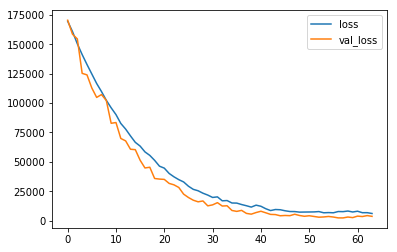

1864/1864 [==============================] - 1s - loss: 5999.1947 - val_loss: 3570.2073


In [13]:
#outputs call and train the model with whatever train test data we put in
#history used to see our various outputs
#data is different if lstm or mlp and we have a lookback

LEARNING_RATE = 0.002
model, history = run_regression(trainX, trainY, testX, testY, lookback, 
                                LEARNING_RATE, BATCH_SIZE_LSTM, EPOCHS, layer1_2neurons, dropout, decay)

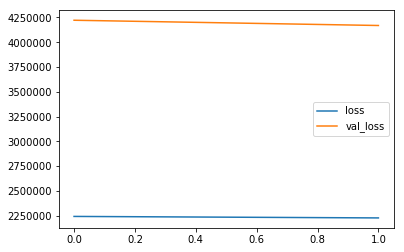

1864/1864 [==============================] - 0s - loss: 2225958.7564 - val_loss: 4168952.0000


NameError: name 'end_time' is not defined

In [17]:
import yaml
reg_list = "reg_list.yml"


with open("data/" + reg_list, 'r') as stream:
    try:
        regression_dict = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

reg_list = []
for reg in regression_dict:
    temp_reg = {}
    for x in regression_dict[reg]:
        for key, value in x.items():
            temp_reg[key] = value
    reg_list.append(temp_reg)
    
run_set_regressions(reg_list)

In [ ]:
model.summary()

In [ ]:
####now we some outputs, performance tests and pretty graphs maybe ?!
bugger = model.predict(trainX)
plt.plot(bugger)
plt.plot(trainY)
plt.show()


In [ ]:
bugger_test = model.predict(testX)
plt.plot(bugger_test)
plt.plot(testY)
plt.show()

len(bugger_test) == len(testY)

In [ ]:
# plot train and validation loss
plt.plot(history.history['loss'][-1000:])
plt.plot(history.history['val_loss'][-1000:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#stuff to look at outputs

diff_bugger = np.diff(bugger[:,0])
diff_bugger = [1 if x > 0 else 0 for x in diff_bugger]
diff_trainY = np.diff(trainY)
diff_trainY = [1 if x > 0 else 0 for x in diff_trainY]

#confusions matrix on the train set
c = confusion_matrix(diff_bugger, diff_trainY, labels=[0,1])
print(c)
print((c[0,0]+c[1,1])/((c[0,0]+c[1,1]) +(c[0,1]+ c[1,0])))

In [ ]:
diff_bugger_test = np.diff(bugger_test[:,0])
diff_bugger_test = [1 if x > 0 else 0 for x in diff_bugger_test]
diff_testY = np.diff(testY)
diff_testY = [1 if x > 0 else 0 for x in diff_testY]


#confusion matrix on the val set 
c = confusion_matrix(diff_bugger_test, diff_testY, labels=[0,1])
print(c)
print((c[0,0]+c[1,1])/((c[0,0]+c[1,1]) +(c[0,1]+ c[1,0])))

In [ ]:
### Adding goodness of fit measures
# MAPE
def compute_mape(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sum(np.abs((y-y_pred) / y)) / len(y)

def compute_r(y, y_pred):
    assert len(y) == len(y_pred)
    mean_pred = np.mean(y_pred)
    return  np.dot(y - mean_pred, y_pred - mean_pred) / np.sqrt(np.sum(np.square(y - mean_pred)) * np.sum(np.square(y_pred - mean_pred)))

def compute_theil_u(y, y_pred):
    assert len(y) == len(y_pred)
    
    n = len(y)
    temp = np.sqrt(np.sum(np.square(y)) / n)
    temp += np.sqrt(np.sum(np.square(y_pred)) / n)
    temp = np.sqrt(np.sum(np.square(y - y_pred)) / n) / temp 
    return temp

predY = bugger_test[:,0]
print(compute_mape(testY, predY))
print(compute_r(testY, predY))
print(compute_theil_u(testY, predY))

In [ ]:
predY = bugger_test[:,0]
print("MAPE: {0:.4f}".format(compute_mape(testY, predY)))
print("R: {0:.4f}".format(compute_r(testY, predY)))
print("THEIL U: {0:.4f}".format(compute_theil_u(testY, predY)))

In [ ]:
# Profitability

BUY_COST = 0.25/100
SELL_COST = 0.45/100

def daily_pnl(y_tomorrow, y_today, buy=True, buy_cost=BUY_COST, sell_cost=SELL_COST):
    if(buy):
        return (y_tomorrow - y_today - (sell_cost*y_tomorrow + buy_cost*y_today)) / y_today
    else:
        return (y_today - y_tomorrow - (buy_cost*y_today + sell_cost*y_tomorrow)) / y_today
    

def buy_and_sell(y_truth, y_pred):
    assert len(y_pred) == len(y_truth)
    n = len(y_pred)
    # Vector of 1s for buy, 0s for sell. Approx: no exact predictions...
    buy_sell = [1 if y_pred[index+1] > y_truth[index] else -1 if y_pred[index+1] < y_truth[index] else 0 for index in range(n-1)]
    ret = [daily_pnl(y_truth[index+1], y_truth[index]) if buy_sell[index] == 1 else
           daily_pnl(y_truth[index+1], y_truth[index], buy=False) for index in range(n-1)]
    return np.sum(ret)*100
    

In [ ]:
buy_and_sell(bugger_test, testY)

#  Change to WT make_raw_data ?

In [ ]:
# Create new features including momentum:

x_train_new = np.genfromtxt('data/cheat.csv', delimiter=',', dtype=None, names=True)

# Momentum
def create_returns(vector, log_returns=False):
    if log_returns:
        return np.diff(np.log(vector))
    else:
        return np.diff(vector)
    
def create_momentum(vector, univariate=True):
    ret_d = create_returns(vector, log_returns=True)
    ret_d[np.isnan(ret_d)] = 0 #Nan values set to 0. it will correspond to carry over when cumulating
    
    if univariate:
        ret_d = ret_d.reshape(ret_d.shape[0], 1)
        
    ret_d_sliding = np.zeros([ret_d.shape[0]-19,20,ret_d.shape[1]])

    for i in range(0, len(ret_d)-19):
        ret_d_sliding[i,:,:] = ret_d[i:i+20,:]

    ret_d_sliding = ret_d_sliding[((52*5)):,:,:]
    ret_d_sliding = ret_d_sliding[np.arange(0,ret_d_sliding.shape[0],5),:,:]
    
    cumRet_d = np.cumsum(ret_d_sliding,1)
    
    mean_d = np.mean(cumRet_d, 1)
    
    std_d = np.std(cumRet_d, 1)
    print(cumRet_d[1].shape)
    
    d_Zscore = (cumRet_d - np.tile(mean_d[:,:,np.newaxis],(1,1,cumRet_d.shape[2]))) / np.tile(std_d[:,:,np.newaxis],(1,1,cumRet_d.shape[2]))
    return d_Zscore



ok = (create_momentum(x_train_new["Close_Price"]))
plt.plot(ok[:,2])
plt.show()

In [ ]:
daily_pr = data[3:,1:]

ret_d = np.diff(np.log(daily_pr))
ret_d[np.isnan(ret_d)] = 0 #Nan values set to 0. it will correspond to carry over when cumulating
ret_w = np.sum(np.reshape(ret_d, (int(ret_d.shape[0]/5),5,ret_d.shape[1])), axis=1)

ret_w_sliding = np.zeros([ret_w.shape[0]-51,52,ret_w.shape[1]])
ret_d_sliding = np.zeros([ret_d.shape[0]-19,20,ret_d.shape[1]])

for i in range(0, len(ret_w)-51):
    ret_w_sliding[i,:,:] = ret_w[i:i+52,:]
     
for i in range(0, len(ret_d)-19):
    ret_d_sliding[i,:,:] = ret_d[i:i+20,:]

ret_w_sliding = ret_w_sliding[0:-4,:,:]
ret_d_sliding = ret_d_sliding[((52*5)):,:,:]
ret_d_sliding = ret_d_sliding[np.arange(0,ret_d_sliding.shape[0],5),:,:]

cumRet_d = np.cumsum(ret_d_sliding,1)
cumRet_w = np.cumsum(ret_w_sliding,1)

mean_d = np.mean(cumRet_d,2)
mean_w = np.mean(cumRet_w,2)
std_d = np.std(cumRet_d,2)
std_w = np.std(cumRet_w,2)

d_Zscore = (cumRet_d - np.tile(mean_d[:,:,np.newaxis],(1,1,cumRet_d.shape[2]))) / np.tile(std_d[:,:,np.newaxis],(1,1,cumRet_d.shape[2]))
w_Zscore = (cumRet_w - np.tile(mean_w[:,:,np.newaxis],(1,1,cumRet_w.shape[2]))) / np.tile(std_w[:,:,np.newaxis],(1,1,cumRet_w.shape[2]))


In [15]:
def run_set_regressions(params_list):
    output_list = []   
    for param in params_list:
        # Start timer
        start_time = time.time()
        if param['lookback'] != 0:
            layers_to_neurons =  param['LSTM_neurons']
        else:
            layers_to_neurons =  param['MLP_neurons']

        #get data - potentially wavelet transformed, and potentially with a cheat and cheat_fac
        x_train, y_train = make_raw_data(param['input_file'], param['features'], param['wavelet'], 
                                         param['normalise'], param['cheat'], param['cheat_fac'])
        #then get the output from the autoencoder
        if param['auto']:
            latent_val = sae(x_train, param['N_EPOCHS'], param['BATCH_SIZE'], 
                             param['LEARNING_RATE'], param['neurons']) #the output is normalised
        else:
            latent_val = x_train #this could be raw data or wavelet output depending on our choice
            latent_val = normalise_dataset(latent_val)

        trainX, trainY, testX, testY = make_reg_data(latent_val, y_train, param['lookback'])   
        
        
        model, history = run_regression(trainX, trainY, testX, testY, 
                                        param['lookback'], param['LEARNING_RATE'], param['BATCH_SIZE_LSTM'], 
                                        param['EPOCHS'], layers_to_neurons, param['dropout'])
        end_time - start_time - time.time()
        predY = model.predict(testX)
        
        performance_metrics = {'MAPE': compute_mape(testY, predY),
                              'R': compute_r(testY, predY),
                              'theilU': compute_theil_u(testY, predY),
                              'buy_and_sell': buy_and_sell(testY, predY),
                               'preparation_and_training_time':end_time,
                              'testY': np.array(testY),
                              'predY': np.array(predY)}
        performance_metrics = np.array(performance_metrics)
        
        
        # Saving everything
        model.save(params_list['input_file'] + ".h5")
        np.save(performance_metrics, params_list['input_file'] + ".npy")
        
        output_list.append((param, model, history, performance_metrics))
    
    return output_list
         
def cross_validate(parameters, list_to_pick_from, name_param):
    assert name_param in parameters.keys() # check if name exists
    params_list = []
    
    for hyperparam in list_to_pick_from:
        pr = parameters.copy()
        pr[name_param] = hyperparam
        params_list.append(pr)
        
    output_list = run_set_regressions(params_list)
    
    # final validation loss as mean loss value over the last 10 epochs:
    val_losses = [np.mean(oupt[2].history['val_loss'][-10:]) for oupt in output_list]
    print("val_losses".format(val_losses))
    return list_to_pick_from[np.argmin(val_losses)]
    

In [16]:
def plot_loss_vs_epoch(history):
    # plot train and validation loss
    plt.plot(history.history['loss'][-1000:])
    plt.plot(history.history['val_loss'][-1000:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
for output in output_list:
    plot_loss_vs_epoch(output[2])

NameError: name 'output_list' is not defined

In [ ]:
input_file = "sp500_index_data.csv"

#select which features we are going to examine
features = ['Close Price', 'Open Price', 'High Price', 'Low Price',
           'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5',
           'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index', 'Federal Fund Rate']
cheat = False
cheat_fac = 0.0 
normalise = True #normalise data

wavelet = False #use wavelet transform
auto = False #use autoenconder - if no to both the raw normalised data goes into the lstm or mlp
lookback = 4 #if 0 an MLP else the lookback period for an lstm
dropout=0.0 #dropout parameter for generalisation tuning

#autoencoder settings using relu activation
N_EPOCHS=1000
neurons = [20,15,15,10] #number of neurons for each layer of the stacked autoencoder
BATCH_SIZE = 60
LEARNING_RATE = 0.005 

#LSTM or MLP Settings
BATCH_SIZE_LSTM = 50
EPOCHS = 500
LSTM_neurons = [50,20]
MLP_neurons = [20,10]


parameters = {
    'lookback':lookback,
    'LEARNING_RATE':LEARNING_RATE,
    'BATCH_SIZE_LSTM':BATCH_SIZE_LSTM,
    'EPOCHS':EPOCHS,
    'layer1_2neurons':layer1_2neurons,
    'dropout':dropout,
    'cheat':cheat,
    'cheat_fac':cheat_fac,
    'wavelet':wavelet,
    'auto':auto,
    'N_EPOCHS':N_EPOCHS,
    'BATCH_SIZE':BATCH_SIZE,
    'LSTM_neurons':LSTM_neurons,
    'MLP_neurons':MLP_neurons,
    'features':features,
    'input_file':input_file,
    'normalise':normalise
}





In [ ]:

# How to use cross validation functions?
list_hyper = [0.05, 0.2, 0.005]
cross_validate(parameters, list_lr, 'LEARNING_RATE')

In [ ]:
op[0][3]